In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from pyvis import network as net
from pyvis.network import Network
import random
#from serpapi import GoogleScholarSearch
import json
import requests

# Creation of DataFarme

In [13]:
#import given dataframe nodes
nodes = pd.read_csv("/Users/enrico/Desktop/ProgettoSocialComputing/Data/nodes.csv")

nodes['author_id'] = None
nodes['cited_by'] = None 
nodes['interests'] = None
nodes.to_csv('Data/nodes.csv', index=False)

edges = pd.DataFrame(columns=['author1','author2']) 
edges.to_csv('Data/edges.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/ProgettoSocialComputing/Data/nodes.csv'

## ES 1
A partire da nodes.csv, utilizzare la libreria Python SerpAPI per scaricare, per ciascuno dei 7 autori elencati:
- author_id: ID identificativo del profilo Google Scholar
- cited_by: numero totale di citazioni ricevute
- interests: elenco degli interessi di ciascun autore
Sfruttando la libreria Python Pandas, usare la struttura dati DataFrame per aggiornare il file originale con apposite colonne e memorizzarlo nella cartella /data.

In [1]:
#dictionary with the keys
listApikey ={
    'SERP_API_KEY_FAVA': "1ae8a37d9b3dabb5732fcd7a9cb57410194766951242a4f4ac5bbd9fb7012048", 
    'SERP_API_KEY_LIGUGNANA': "11a077a8bee5bb1c2a25af914046bc7ce53050b3416e5720239e43223c63374b",
    'SERP_API_KEY_PARAVANO' :  "42b4919fd319f0ff32c19ae31a88b4ff67a544e29ca2a017905088b2ae11e60e",
    'SERP_API_KEY_TAMMARO': "6eaf5a9a0d2eef8bf026a947a3dffbb0d31cb1d6e122b81c0e6062f6b23a4c40"
}

#key in use right now
apikey = "1ae8a37d9b3dabb5732fcd7a9cb57410194766951242a4f4ac5bbd9fb7012048"

#function to randomise the key in use
'''
def key_choice():
    return random.choice(list(apikey.items()))[1]
'''


'\ndef key_choice():\n    return random.choice(list(apikey.items()))[1]\n'

In [141]:
#overwrite the row of nodes with df_update in the right position
#if the author given isn't in nodes, then it will get concatenated

def update_nodes(df_update):
    
    #read nodes csv
    nodes = pd.read_csv(r'Data/nodes.csv') 

    #check if the author is in nodes using attributre name as parameter
    if (nodes["name"] == df_update["name"][0]).any():
        #if author is already in nodes update the present row with df_update
        for index in range(len(nodes)):
            if nodes["name"][index] == df_update["name"][0]:
                nodes.iloc[index]=df_update.iloc[0]
                nodes.to_csv(r'Data/nodes.csv', index=False) #overwrite the csv with the new row
    else:
        #if the author isn't already in nodes we concatenete it
        nodes = pd.concat([nodes, df_update], ignore_index=True)
        nodes.to_csv(r'Data/nodes.csv', index=False) #overwrite the csv by adding df_update at the end
            

In [154]:
#author_profile returns a dataframe with name, affiliations, author_id, cited_by, interests of a given author

def author_profile(apiKey, name, affiliation):
    
    base_url = "https://serpapi.com/search"
    
    #search among scholar profiles for the one with the given name
    params = {
        "api_key": apiKey,
        "engine": "google_scholar_profiles",
        "hl": "en",
        "mauthors": name
    }      
    
    #save the request response in json
    response = requests.get(base_url, params = params)
    results = response.json()
    nodes = pd.read_csv(r'Data/nodes.csv') 

    #scroll through profiles to verifies if the profile found is the one that wa are searching for
    for profile in results["profiles"]:
        
        #affiliation and name are those given as input to the function
        if profile["affiliations"] == affiliation and profile["name"] == name:
                
            #save the information needed for the right author
            authorId = profile["author_id"] 
            citedBy = profile["cited_by"]
            if "interests" in profile:
                interests = ", ".join([i['title'] for i in profile["interests"]]) #select only titles for each interest, join to remove the square brackets (now seen as a single string instead of a list) 
            else:
                interests = None

            #create a new row of the dataframe with all the information needed and return it
            df_update = pd.DataFrame({'name': [name],
                               'affiliations': [affiliation],
                               'author_id': [authorId],
                               'cited_by': [citedBy],
                               'interests': [interests]})
            
            #update the nodes row with additional author information
            update_nodes(df_update)    

In [161]:
author_profile(apikey,"Beatrice Portelli" , "University of Udine")


In [159]:
#nodes_information return a dataframe with name, affiliations, author_id, cited_by, interests;
#for each node in the given dataframe containing name and affiliation for each author 

def nodes_information(apikey, df):
    
    #iterate the row of the given df, for each one makes the call to the author_profile
    for index, row in df.iterrows():
        author_data = author_profile(apikey, row['name'], row['affiliations'])
        

## Main es 1

In [142]:
#get the final dataframe of the 7 originals authors with name, affiliations, author_id, cited_by, interests 
nodes_information(apikey, nodes)

## 2. Analisi dei Coautori tramite SerpAPI su Google Scholar

### a. Ottenere i Coautori dei 7 Autori Principali

Per ciascuno dei 7 autori, utilizzare il suo ID per accedere al relativo profilo Google Scholar e scaricare l'elenco dei suoi coautori utilizzando SerpAPI. Con tale elenco di nomi:;

#### a.1. Ricerca dei Coautori su Google Scholar

Utilizzare le SerpAPI per cercare su Google Scholar un ricercatore che corrisponde a ciascun nome nella lista di coautori. Per ogni risultato, salvare le informazioni come `name`, `affiliations`, `author_id`, `cited_by`, e `interests` in un nuovo DataFrame contenente tutte queste informazioni relative ai coautori dei 7 autori originari.

### b. Concatenazione dei DataFrame

Concatenare il DataFrame contenente le informazioni sui 7 autori principali con quello dei coautori generato al punto 2a in un unico DataFrame.

### c. Creazione del DataFrame delle Relazioni di Co-Authorship

Creare un terzo DataFrame con le colonne `author1` e `author2` che rappresenta le co-authorship. In questo DataFrame, una riga rappresenta un arco di coauthorship tra due autori. La co-authorship è binaria, non pesata.

#### Esempio

Se David La Barbera e Michael Soprano sono coautori, una riga del DataFrame creato al punto 2c rappresenterà questa relazione.

### Risultati Finali

A questo punto, saranno stati prodotti due DataFrame:

- Uno contenente le informazioni relative agli autori (originali + i relativi coautori), con le colonne `name`, `affiliations`, `cited_by`, `interests`. Salvare come `nodes.csv` nella cartella `/data` tale DataFrame.

- Un altro per le relazioni di co-authorship dai 7 autori principali verso i relativi coautori, con colonne `author1` e `author2`. Salvare come `edges.csv` nella cartella `/data` tale DataFrame.










In [150]:
#return a list with the co-authors id

def get_profile_coauthors(apiKey, authorID):
    base_url = "https://serpapi.com/search"

    #search among scholar profiles for the one with the given author_id
    params = {
        "api_key": apiKey,
        "engine": "google_scholar_author",
        "hl": "en",
        "author_id": authorID
    }

    response = requests.get(base_url, params = params)
    results = response.json()

    #estrarre solo parte di coautrori dal dataframe grade del autore,

    #crea solo un dataFrame con colonna name e affiliations
    df_coAuthors = pd.DataFrame(columns=['name','affiliations'])

    #for each coauthor save name and affiliation in a dataframe
    for author in results['co_authors']:
        row = {'name' : author['name'], 'affiliations': author['affiliations']}
        new_coauthor = pd.DataFrame([row])

        df_coAuthors = pd.concat([df_coAuthors, new_coauthor], ignore_index=True)



        #adding coauthors to nodes
        author_profile(apiKey, author['name'], author['affiliations'])


    authorName = results["author"]

    #import edges.csv
    edges = pd.read_csv(r'Data/edges.csv')

    #create the new edge from the given author to each coauthor from df_coAuthors -> update edges
    for author in df_coAuthors["name"]:
        row = {'author1' : authorName["name"], 'author2': author}
        new_edges = pd.DataFrame([row])
        edges = pd.concat([edges, new_edges], ignore_index=True) #concatenete the edge of the given author to the original edges

    #overwrite edges with the new one
    edges.to_csv(r'Data/edges.csv', index=False)

# fare una funzione che cicli su tutti i coautori e riempia edges (senza quelli già presenti)
# modificare la prima funzione per mettere direttametne in nodes i coautori e affiliations



In [ ]:
######################################
#Prova chiedi a cara se puoi eliminare
######################################
#gg
def get_profile_coauthors(apiKey, authorID):
    base_url = "https://serpapi.com/search"

    #search among scholar profiles for the one with the given author_id
    params = {
        "api_key": apiKey,
        "engine": "google_scholar_author",
        "hl": "en",
        "author_id": authorID
    }
    response = requests.get(base_url, params = params)
    results = response.json()
    #crea solo un dataFrame di appoggio con colonna name e affiliations, secondo me non serve, ammno che non venga usato da qualche aletra parte
    authorName = results["author"]
    edges = pd.read_csv(r'Data/edges.csv')
    #for each coauthor save name and affiliation in a dataframe
    for coautore in results['co_authors']:
        coppie_da_cercare = [(authorName["name"], coautore['name']), (coautore['name'], authorName["name"])]
        #Cicla attraverso il DataFrame e verifica le condizioni
        trovato = True
        for index, row in edges.iterrows():
            if (row['author1'], row['author2']) in coppie_da_cercare or (row['author2'], row['author1']) in coppie_da_cercare:
                #esiste gia un collegamento tra aurtore e coautore o viceversa
                trovato = False
        if(trovato):
            row_edge = pd.DataFrame([{'author1' : authorName["name"], 'author2': coautore['name']}])
            edges = pd.concat([edges, row_edge], ignore_index=True)
        #adding coauthors to nodes
        author_profile(apiKey, coautore['name'], coautore['affiliations'])
    edges.to_csv(r'Data/edges.csv', index=False)
# fare una funzione che cicli su tutti i coautori e riempia edges (senza quelli già presenti)
# modificare la prima funzione per mettere direttametne in nodes i coautori e affiliations

author1
author2


## Main es 2

In [151]:
##df_Coauthors = pd.DataFrame(columns=['name','affiliations','author_id','cited_by','interests'])
nodes = pd.read_csv(r'Data/nodes.csv') 
for autore in nodes["author_id"]:
    get_profile_coauthors(apikey,autore)


KeyError: 'interests'

In [ ]:

#salvare edges e ogni volta concatenare il risulatato a edges salvato in locale
#






# Parte 3
Usare il due dataset per creare grafico indiretto:
a. Generare un grafo indiretto che ne rappresenta le informazioni contenute.
Salvare (serializzare) il grafo in locale nella cartella /graphs .
b. Visualizzare il grafo prodotto colorando i nodi a seconda del loro grado con le
seguenti colorazioni: grigio per nodi con grado uguale a 1, blu per nodi con grado compreso tra 2 e 10, viola per nodi con grado compreso tra 11 e 20, giallo per nodi con grado maggiore di 20. Inoltre, per ciascun nodo visualizzare il nome dell’autore. Salvare la visualizzazione nella cartella /visualizations.




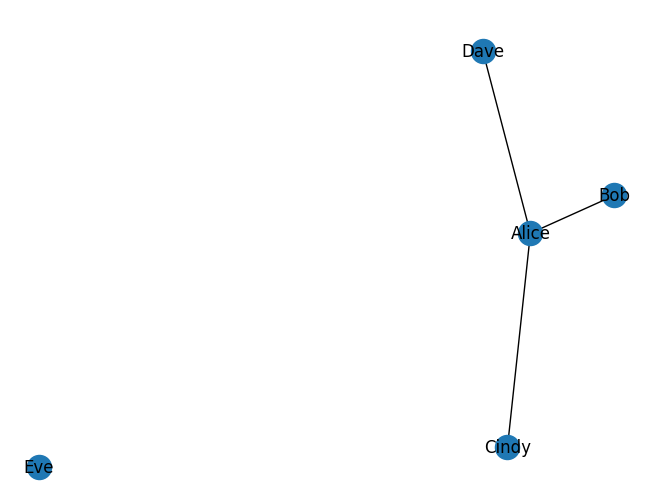

In [129]:
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edge('Alice', 'Bob')
G.add_edge('Alice', 'Cindy')
G.add_edge('Alice', 'Dave')
G.add_node('Eve')  # Eve non è connessa a nessuno, la aggiungo a mano

# 1.2 | Aggiungo gli attributi ai nodi
for node in G.nodes:
    G.nodes[node]['name'] = node
    G.nodes[node]['age'] = random.randint(20, 30) 

# 1.3 | Visualizzo il grafo
nx.draw(G, with_labels=True)
plt.show()


Centralità di grado:


,node,degree
0,0,5
1,1,4
2,2,3
3,3,5
4,4,4
5,5,4
6,6,7
7,7,4
8,8,4
9,9,3


Number of edges: 30
Average degree: 4.00
Density: 0.29
Most connected node: 6


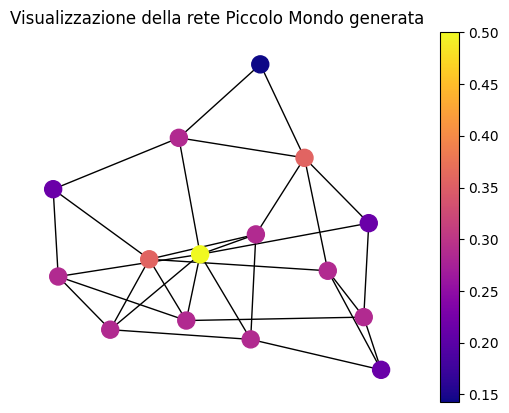

In [130]:
#ES 2
def draw(G, pos, measures, title):
    nodes = nx.draw_networkx_nodes(G, pos, node_size = 150, cmap = plt.cm.plasma,
                                   node_color  = list(measures.values()),
                                   nodelist = measures.keys()
                                   )
    edges = nx.draw_networkx_edges(G, pos)
    plt.title(title)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()
    # 2.1 | Genero grafo con proprietà piccolo mondo
G = nx.watts_strogatz_graph(15, 4, .3)

# 2.2 | Centralità di grado per tutti i nodi
degrees = dict(G.degree())
df = pd.DataFrame(list(degrees.items()), columns=['node', 'degree'])
print("Centralità di grado:")
display(df)


# 2.3 | Calcolo le altre priprietà richieste
num_edges = G.number_of_edges()
# Grado medio 
avg_degree = sum(degrees.values()) / G.number_of_nodes()
# Densità del grafo
density = nx.density(G)
# Nodo più connesso
max_degree_node = max(degrees, key=degrees.get)

print(f"Number of edges: {num_edges}")
print(f"Average degree: {avg_degree:.2f}")
print(f"Density: {density:.2f}")
print(f"Most connected node: {max_degree_node}")
# 2.4 | Visualizzo usando lo spring layout
draw(
    G,
    nx.spring_layout(G),
    nx.degree_centrality(G),
    title = "Visualizzazione della rete Piccolo Mondo generata"
      )

In [1]:




#usare la stessa funzione iniziale, quando passi l'id del autore e restituisce tutti i dati, di cui recuprei i coautori, crei direttamente il datframe quello dei nodi, ciclano n-volte( che saranno il numero di coaurori, e crei una riga insrendo l'Id del autore + vicino il coautore.

NameError: name 'nodes' is not defined